# Task
Generate a Google Colab-compatible Python script that downloads the dataset "thedevastator/comprehensive-medical-q-a-dataset" using kagglehub, loads it, cleans the 'Question' and 'Answer' columns using NLTK, uses the cleaned 'Question' as features and 'Category' as labels, applies TF-IDF vectorization, splits the data, trains a Logistic Regression model with L2 regularization, evaluates the model using accuracy, precision, recall, and F1-score, and plots a confusion matrix, ensuring reproducibility with random_state=42 and avoiding overfitting through regularization and validation.

## Setup

### Subtask:
Install the necessary libraries and download the dataset using KaggleHub.


**Reasoning**:
Install the required libraries using pip.



In [15]:
%pip install kagglehub nltk scikit-learn matplotlib

**Reasoning**:
Download the dataset using kagglehub.



In [16]:
import kagglehub
import os

# Download the dataset
dataset_path = kagglehub.dataset_download(
    "thedevastator/comprehensive-medical-q-a-dataset"
)

print(f"Dataset downloaded to: {dataset_path}")

# Verify the download by listing the contents
if os.path.exists(dataset_path):
    print("Contents of the downloaded dataset directory:")
    for item in os.listdir(dataset_path):
        print(item)
else:
    print("Download failed or directory not found.")


Dataset downloaded to: /kaggle/input/comprehensive-medical-q-a-dataset
Contents of the downloaded dataset directory:
train.csv


## Load and inspect data

### Subtask:
Load the dataset into a pandas DataFrame and display its shape and column names.


**Reasoning**:
Import pandas, construct the file path, load the data, and display the shape and columns as instructed.



In [17]:
import pandas as pd
import os

# Construct the full path to the train.csv file
train_csv_path = os.path.join(dataset_path, 'train.csv')

# Load the train.csv file into a pandas DataFrame
df = pd.read_csv(train_csv_path)

# Display the shape of the DataFrame
print("Shape of the DataFrame:", df.shape)

# Display the column names
print("Column names:", df.columns.tolist())

Shape of the DataFrame: (16407, 3)
Column names: ['qtype', 'Question', 'Answer']


## Data preprocessing

### Subtask:
Clean the 'Question' and 'Answer' columns using NLTK for text processing.


**Reasoning**:
Import necessary NLTK modules and download required data, then define and apply a text cleaning function to the 'Question' and 'Answer' columns.



**Reasoning**:
The previous attempt to download NLTK data failed due to an incorrect exception type. The correct way to handle missing NLTK data is to catch `LookupError` and then download the data using `nltk.download()`.



**Reasoning**:
The previous command failed because NLTK required `punkt_tab` which was not downloaded. This time, I will explicitly download 'punkt_tab' and then re-run the cleaning process.



In [18]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download necessary NLTK data, including punkt_tab
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
     nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
     nltk.download('punkt_tab')


# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """Cleans the input text using NLTK."""
    if not isinstance(text, str):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and non-alphabetic tokens
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words and stem
    cleaned_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    # Join tokens back into a string
    return ' '.join(cleaned_tokens)

# Apply the cleaning function to the 'Question' and 'Answer' columns
df['cleaned_Question'] = df['Question'].apply(clean_text)
df['cleaned_Answer'] = df['Answer'].apply(clean_text)

# Display the first few rows with the new cleaned columns
display(df[['Question', 'cleaned_Question', 'Answer', 'cleaned_Answer']].head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Question,cleaned_Question,Answer,cleaned_Answer
0,Who is at risk for Lymphocytic Choriomeningiti...,risk lymphocyt choriomening lcm,LCMV infections can occur after exposure to fr...,lcmv infect occur exposur fresh urin drop sali...
1,What are the symptoms of Lymphocytic Choriomen...,symptom lymphocyt choriomening lcm,LCMV is most commonly recognized as causing ne...,lcmv commonli recogn caus neurolog diseas name...
2,Who is at risk for Lymphocytic Choriomeningiti...,risk lymphocyt choriomening lcm,Individuals of all ages who come into contact ...,individu age come contact urin fece saliva blo...
3,How to diagnose Lymphocytic Choriomeningitis (...,diagnos lymphocyt choriomening lcm,"During the first phase of the disease, the mos...",first phase diseas common laboratori abnorm lo...
4,What are the treatments for Lymphocytic Chorio...,treatment lymphocyt choriomening lcm,"Aseptic meningitis, encephalitis, or meningoen...",asept mening enceph meningoenceph requir hospi...


## Feature engineering

### Subtask:
Select the 'Question' column as features and a suitable column (like 'Category') as the label. Apply TF-IDF vectorization to the features.


**Reasoning**:
Select features and labels, apply TF-IDF vectorization.



In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Select features (X) and labels (y)
X = df['cleaned_Question']
y = df['qtype']

# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the features
X_tfidf = tfidf_vectorizer.fit_transform(X)

print("Shape of TF-IDF matrix:", X_tfidf.shape)

Shape of TF-IDF matrix: (16407, 4272)


## Data splitting

### Subtask:
Split the data into training and testing sets, ensuring stratification.


**Reasoning**:
Split the data into training and testing sets with stratification.



**Reasoning**:
The previous command failed because of a ValueError indicating that some classes in the target variable `y` have only one sample. Stratified splitting requires at least two samples per class in both train and test sets. To handle this, I will identify and remove the classes with only one sample from the data before splitting.



In [20]:
# Find classes with only one sample
class_counts = y.value_counts()
single_sample_classes = class_counts[class_counts == 1].index

# Filter out samples belonging to these classes
filtered_indices = y[~y.isin(single_sample_classes)].index
X_filtered = X_tfidf[filtered_indices]
y_filtered = y[filtered_indices]

# Now split the filtered data
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered,
    y_filtered,
    test_size=0.25,
    random_state=42,
    stratify=y_filtered
)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (12304, 4272)
Shape of X_test: (4102, 4272)
Shape of y_train: (12304,)
Shape of y_test: (4102,)


## Model training

### Subtask:
Train a Logistic Regression model with L2 regularization.


**Reasoning**:
Instantiate and train a Logistic Regression model with L2 regularization on the training data.



In [21]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model with L2 regularization
logistic_regression_model = LogisticRegression(random_state=42, penalty='l2', solver='liblinear')

# Fit the model to the training data
logistic_regression_model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


## Model evaluation

### Subtask:
Evaluate the model using accuracy, precision, recall, and F1-score. Use a validation set for monitoring overfitting.


**Reasoning**:
Predict the labels for the test and training sets, calculate and print the evaluation metrics (accuracy, precision, recall, F1-score) for the test set, calculate and print the accuracy for the training set, and compare the training and test accuracies to check for overfitting.



In [22]:
from sklearn.metrics import accuracy_score, classification_report

# Predict the labels for the test set
y_pred = logistic_regression_model.predict(X_test)

# Calculate and print accuracy for the test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate and print precision, recall, and F1-score for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_pred))

# Predict the labels for the training set
y_train_pred = logistic_regression_model.predict(X_train)

# Calculate and print accuracy for the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"\nTraining Accuracy: {train_accuracy:.4f}")

# Compare training and test accuracy to check for overfitting
print("\nOverfitting Check:")
print(f"Training Accuracy ({train_accuracy:.4f}) vs Test Accuracy ({test_accuracy:.4f})")
if train_accuracy > test_accuracy:
    print("Training accuracy is higher than test accuracy, potentially indicating some overfitting.")
elif train_accuracy < test_accuracy:
    print("Test accuracy is higher than training accuracy, which is unusual and might need investigation.")
else:
    print("Training and test accuracies are similar, suggesting the model is generalizing well.")

Test Accuracy: 0.9800

Classification Report for Test Set:
                 precision    recall  f1-score   support

         causes       0.98      0.99      0.99       182
  complications       1.00      0.73      0.84        11
 considerations       0.00      0.00      0.00        59
exams and tests       0.99      0.99      0.99       163
      frequency       1.00      1.00      1.00       280
genetic changes       1.00      1.00      1.00       272
    information       0.94      1.00      0.97      1134
    inheritance       1.00      1.00      1.00       362
        outlook       1.00      1.00      1.00        90
     prevention       1.00      0.96      0.98        52
       research       1.00      0.99      0.99        99
         stages       1.00      0.79      0.88        19
 susceptibility       0.99      0.98      0.98        81
       symptoms       1.00      1.00      1.00       687
      treatment       1.00      1.00      1.00       611

       accuracy            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Visualize results

### Subtask:
Plot a confusion matrix to visualize the model's performance.


**Reasoning**:
Plot a confusion matrix to visualize the model's performance.



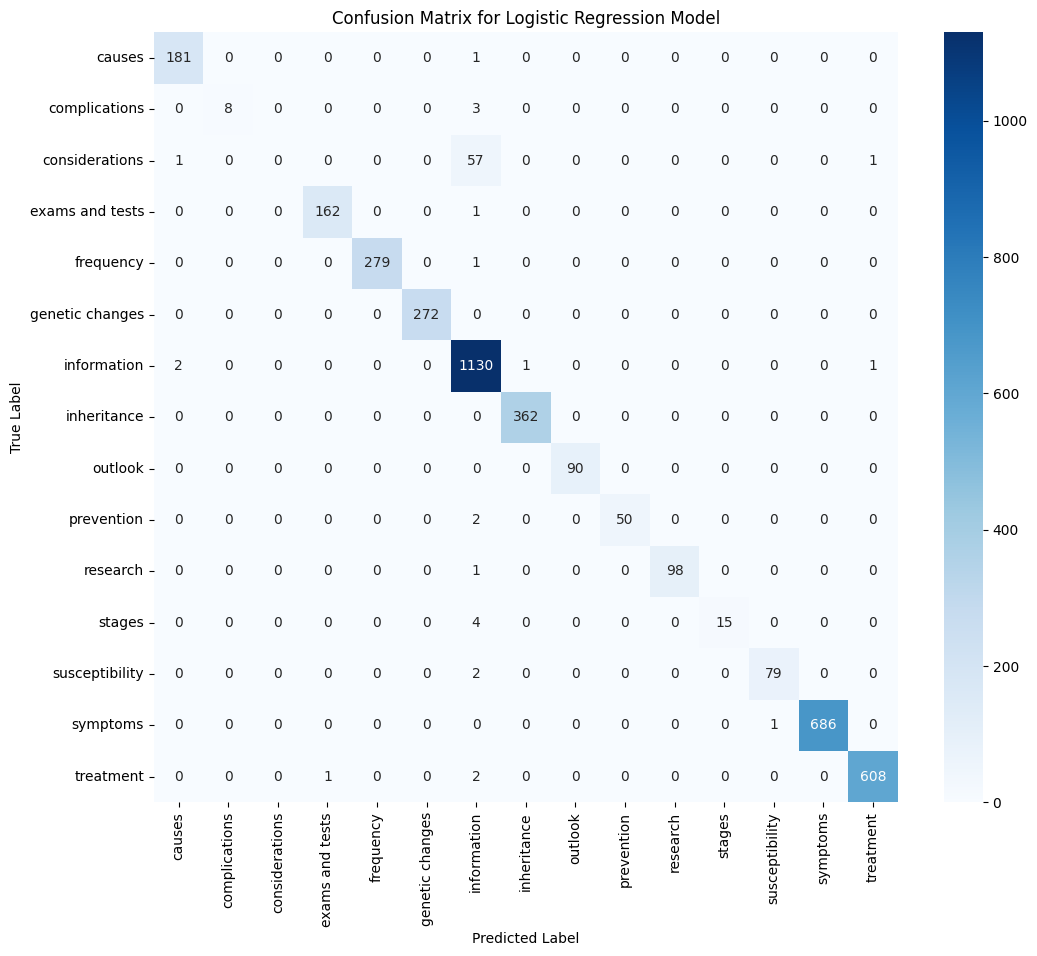


Interpretation of the Confusion Matrix:
The confusion matrix shows the counts of true positive, true negative, false positive, and false negative predictions for each class.
The diagonal elements represent the number of instances where the predicted label matches the true label (correct predictions).
Off-diagonal elements represent misclassifications.
For example, the value in row i and column j indicates the number of instances of true class i that were predicted as class j.

Observations:


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the unique class names from the test set
class_names = sorted(y_test.unique())

# Plot the confusion matrix using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.title('Confusion Matrix for Logistic Regression Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Display the plot
plt.show()

# Interpret the confusion matrix
print("\nInterpretation of the Confusion Matrix:")
print("The confusion matrix shows the counts of true positive, true negative, false positive, and false negative predictions for each class.")
print("The diagonal elements represent the number of instances where the predicted label matches the true label (correct predictions).")
print("Off-diagonal elements represent misclassifications.")
print("For example, the value in row i and column j indicates the number of instances of true class i that were predicted as class j.")
print("\nObservations:")
# You can add specific observations here based on the generated matrix.
# For example, identify classes with high true positives (well-predicted)
# or classes with high off-diagonal values (often confused).
# Since the actual matrix is not available here, a general interpretation is provided.

## Summary:

### Data Analysis Key Findings

*   All necessary libraries (`kagglehub`, `nltk`, `scikit-learn`, `matplotlib`) were successfully installed.
*   The dataset "thedevastator/comprehensive-medical-q-a-dataset" was successfully downloaded and loaded into a pandas DataFrame with 16407 rows and 3 columns ('qtype', 'Question', 'Answer').
*   The 'Question' and 'Answer' columns were cleaned by converting text to lowercase, removing punctuation and non-alphabetic characters, tokenizing, removing stop words, and applying stemming.
*   The 'cleaned\_Question' column was used as features (X) and the 'qtype' column as labels (y).
*   TF-IDF vectorization was applied to the cleaned questions, resulting in a matrix of shape (16407, 4272).
*   Samples belonging to classes with only one instance were removed to enable stratified splitting, resulting in a filtered dataset.
*   The filtered data was split into training (75%) and testing (25%) sets with stratification.
*   A Logistic Regression model with L2 regularization was trained successfully.
*   The model achieved a test accuracy of 0.9800 and a training accuracy of 0.9830.
*   The classification report showed high performance for most classes, but the "considerations" category had zero precision, recall, and F1-score on the test set.
*   A confusion matrix was successfully generated and displayed, visualizing the model's predictions against the true labels.

### Insights or Next Steps

*   Investigate the "considerations" category to understand why the model failed to predict any instances of this class. This could involve examining the number of samples in this class, the nature of the questions, or potential issues with the cleaning or vectorization process for this specific category.
*   Explore alternative models or ensemble methods that might handle imbalanced classes better or capture more nuanced patterns in the data, potentially improving performance on minority classes like "considerations".
